# Unicity analysis

Here we do not use the panel data (can then use more data).

sketch of what happens here
- divide the 52 weeks into sequences of w=4 weeks
- w then represents a week of browsing data. We do this to make the data bigger.
- Each sequence then contains a set of machines with browsing history in the each of the w weeks in the sequence
- For each w, compute k-anonymous cohorts.
- Use various k
- Map each user to their sequence of cohort IDs. Then consider k-anonymous cohort sequences
- For week 1, sequence [c1]
- For week 2, sequence [c1, c2]

...
And so on
- At each week, how many users are in cohort sequences with k=1?
- How does this change when we also add some weak proxy of fingerprinting data, like US state?


In [3]:
from datetime import datetime
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import floc

from utils.data import read_weeks_machines_domains
import prefixLSH
from style_config import BLUE, ORANGE

## Preprocessing

Set up the data

### Preprocess demographic data for fingerprinting proxy


##### Create mapping from machine ID to U.S. State

Want to use U.S. State as a weak proxy for fingerprinting

Use demographic data file for machine IDs to create mapping from machine id to U.S. State

In [4]:
from pyzipcode import ZipCodeDatabase
import us


YEAR = 2017
demographics_fpath = '../data/comscore/{year}/demographics.csv'.format(year=YEAR)

def get_state_fips(zipcode, err=False):
    """returns a state FIPS for the state with given zipcide.
    
    if it can't find the zip code, return np.nan if err=False.
    
    parameters
    ----------
    err: boolean. True if function should raise a ValueError if it can't find a zip code. False by default.
    """
    zcdb = ZipCodeDatabase()
    if zipcode not in zcdb:
        if err:
            raise ValueError("Zip code not found")
        else:
            return np.nan
    zipcode = zcdb[zipcode]
    state = us.states.lookup(zipcode.state)
    return state.fips


demo_df = (pd.read_csv(demographics_fpath, dtype={'zip_code': str})
           .replace({99:np.nan}))
rows = len(demo_df)
print('%s rows' % rows)
print('dropping rows we cannot find U.S. State data for')
demo_df = (demo_df
           .dropna(subset=['zip_code'])
           # make sure zips are zip5
           .assign(zip_code=lambda x: x.zip_code.apply(lambda z: '0' + z if len(z) < 5 else z))
           # get state fips code for each zip
           .assign(state_fips=lambda x: x.zip_code.apply(lambda z: get_state_fips(z)))
           .dropna(subset=['state_fips'])
           .assign(state=lambda x: x.state_fips.apply(lambda s: us.states.lookup(s).abbr))
          )
print('%s rows after' % len(demo_df))
print('dropped %s rows' % (rows - len(demo_df)))
demo_df.drop('machine_id', axis=1).head()

93808 rows
dropping rows we cannot find U.S. State data for
92884 rows after
dropped 924 rows


,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,state_fips,state
0,NaN,4.0,5.0,8.0,16.0,0.0,1.0,1.0,0.0,98611,53,WA
1,3.0,4.0,3.0,8.0,14.0,0.0,1.0,1.0,0.0,80910,08,CO
2,4.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,07076,34,NJ
3,3.0,2.0,1.0,9.0,16.0,0.0,1.0,1.0,0.0,62554,17,IL
5,1.0,4.0,3.0,7.0,12.0,0.0,1.0,1.0,1.0,93436,06,CA


Extract mapping of machine ID to U.S. State 

In [5]:
machine_state_df = demo_df.set_index('machine_id')[['state_fips', 'state']]
machine_state_df.head()

,state_fips,state
machine_id,,
46569906.0,53,WA
70298839.0,08,CO
76984170.0,34,NJ
76991725.0,17,IL
81191519.0,06,CA


## Preprocess browsing history data

In [6]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [7]:
weeks_machines_domains_df.head()

,machine_id,week,n_domains,domains
0,169007206,1,104,"{nordstromrack.com, azz-overload.net, tenforum..."
1,170331223,1,0,{}
2,170422065,1,20,"{mozilla.org, sammsoft.com, pch.com, ourdailys..."
3,170911221,1,49,"{123.125.123.144, wamu.org, wtoutiao.com, vjav..."
4,171771316,1,64,"{choiceresult.com, cfxway.com, hodges.edu, fac..."


#### Preprocessing: Apply simhash to each machine week

simhash can only be applied when there are at least 7 unique domains for the week

otherwise the cohort ID is null

Compute simhash for machine weeks with >= 7 domains or otherwise assign null value

In [5]:
def assign_simhash(row):
    """Returns simhash value when valid otherwise NaN."""
    if row.n_domains < 7:
        return np.nan
    return floc.hashes.sim_hash_string(row.domains)

In [6]:
weeks_machines_domains_df['simhash'] = weeks_machines_domains_df.apply(assign_simhash, axis=1)

In [7]:
weeks_machines_domains_df.head()

,machine_id,week,n_domains,domains,simhash
0,169007206,1,104,"{2dopeboyz.com, offers.com, wordpress.com, ora...",1.585204e+14
1,170331223,1,0,{},NaN
2,170422065,1,20,"{shein.com, refinery29.com, messenger.com, num...",5.322881e+14
3,170911221,1,49,"{8haodangpu.cc, vjav.com, 51luoben.com, bilibi...",7.213568e+14
4,171771316,1,64,"{youtube.com, thingames.com, hudsonsfurniture....",6.710488e+14


Save to file

In [8]:
wmd_simhash_fpath = '../output/wmd_simhash.csv'

In [9]:
print('saving precomputed weeks machines simhash data to %s...' % wmd_simhash_fpath)
weeks_machines_domains_df.to_csv(wmd_simhash_fpath, index=False)

saving precomputed weeks machines simhash data to ../output/wmd_simhash.csv...


script re-entry point

In [9]:
weeks_machines_domains_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(weeks_machines_domains_df))
weeks_machines_domains_df.drop('domains', axis=1).head()

read in 4877236 total rows


,machine_id,week,n_domains,simhash
0,169007206,1,104,1.585204e+14
1,170331223,1,0,NaN
2,170422065,1,20,5.322881e+14
3,170911221,1,49,7.213568e+14
4,171771316,1,64,6.710488e+14


How many machine weeks with non-null vs null simhash?

domains per week distribution across machines
count        975.0
mean        5002.0
std        60482.0
min            1.0
25%            1.0
50%            2.0
75%           40.0
max      1819210.0
Name: n_domains, dtype: float64


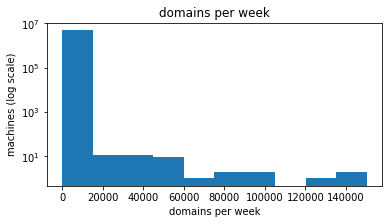

0.43 = 2073405/4877236 machine weeks have >= 7 domains


In [10]:
print('domains per week distribution across machines')
n_domains_value_counts = weeks_machines_domains_df.n_domains.value_counts().sort_index()
print(n_domains_value_counts.describe().round())

fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(weeks_machines_domains_df.n_domains, log=True)
ax.set_title('domains per week')
ax.set_xlabel('domains per week')
ax.set_ylabel('machines (log scale)')
plt.show()

n_domains7 = len(weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= 7])
print('%0.2f = %s/%s machine weeks have >= 7 domains' % (
    n_domains7/len(weeks_machines_domains_df), 
    n_domains7, len(weeks_machines_domains_df))
)

Note all machine IDs occur in all 52 weeks of data.

In [11]:
machine_week_count = weeks_machines_domains_df.groupby('machine_id')['week'].count()
print('\nvalue counts for weeks per machine:')
print(machine_week_count.value_counts())


value counts for weeks per machine:
52    93793
Name: week, dtype: int64


Limit data to machine, weeks with sufficient data for cohort generation: >= 7 domains

In [12]:
n_domains_threshold = 7
print('dropping machine weeks with < %s domains' % n_domains_threshold)
s_before = len(weeks_machines_domains_df)
wmd7_df = weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= n_domains_threshold]
s_after = len(wmd7_df)
print('dropped %s = %s - %s data rows' % ((s_before - s_after), s_before, s_after))

dropping machine weeks with < 7 domains
dropped 2803831 = 4877236 - 2073405 data rows


In [13]:
wmd7_df.head()

,machine_id,week,n_domains,domains,simhash
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14


## Preprocessing: Fold / expand data into 4-week sequences

We have browsing data representing 52 weeks for our observed machines. Fold this to represent W (W=4) weeks of browsing for *more machines* by counting machine browsing weeks as new independent samples every W weeks.


Divide the 52 weeks into W=4 week sequences, noted by column s, and where each week within a sequence is noted by w and w is 0-indexed.

W=4

`s = (week - 1) // W`

i.e. weeks {1,2,3,4} in s=0, weeks {5,6,7,8} in s=1, ...

each week in a sequence is represented by `w`

where `w = (week - 1) % W`

i.e. week 1: w=0, week 2: w=1, ..., week 4: w=3, week 5: w=0, week 7: w=2, ...

Then have rows that represent weeks of machine data, where a single machine will have data for multiple w weeks.

We create another column that names machines prefixed by their sequence.

`s_machine_id` which literally concatenates `s` + `_` + `machine_id`s

(see previous version of this notebook in previous commit that used W=5)

In [14]:
# create new df for folded 4 week sequences data
print('%s rows of data for %s weeks' % (len(wmd7_df), wmd7_df.week.nunique()))

2073405 rows of data for 52 weeks


In [15]:
W=4
wmd_s_df = wmd7_df.copy()
wmd_s_df['s'] = wmd_s_df.week.apply(lambda w: (w - 1) // W)
wmd_s_df['w'] = wmd_s_df.week.apply(lambda w: (w - 1) % W)
wmd_s_df['s_machine_id'] = wmd_s_df[['machine_id','s']].astype(str).apply(lambda x: ('%s_%s'%(x.s, x.machine_id)), axis=1)

In [16]:
wmd_s_df.head()

,machine_id,week,n_domains,domains,simhash,s,w,s_machine_id
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,0,0,0_169007206
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,0,0,0_170422065
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,0,0,0_170911221
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14,0,0,0_171771316
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14,0,0,0_176278357


Limit to machines (`s_machine_id`s) that have data across all weeks (`w`) in a sequence.


value counts for weeks per s_machine_id:
4    305312
1    175151
3    136182
2    134230
Name: w, dtype: int64


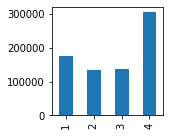

In [17]:
s_machine_w_count = wmd_s_df.groupby('s_machine_id')['w'].count()
print('\nvalue counts for weeks per s_machine_id:')
print(s_machine_w_count.value_counts())
fig,ax = plt.subplots(1,1,figsize=(2,2))
_ = s_machine_w_count.value_counts().sort_index().plot.bar(ax=ax)

In [18]:
m_before = wmd_s_df.s_machine_id.nunique()
wmd_s_df.drop(
    wmd_s_df[(wmd_s_df.s_machine_id.map(s_machine_w_count) < W)].index,
    inplace=True
)
m_after = wmd_s_df.s_machine_id.nunique()
print('%s s_machine_id\'s after dropping those lacking data across all %s w in a sequence (%s before)' % (
    m_after, W, m_before))

305312 s_machine_id's after dropping those lacking data across all 4 w in a sequence (750875 before)


Compute cohorts for each w

Trying a range of k values

starting at k=2000, diminishing by linear increments

OR diminishing by powers of 2?
- k=2000
- k=1000
- k=500
- k=250
- k=125

In [19]:
cohort_ks = list(range(200,2200,200))
# cohort_ks = [2000, 1750, 1500, 1250, 1000, 750, 500, 250]
# cohort_ks = [2000,1000,500,250,125]
# cohort_ks = [2000]

# column names for cohort assignments for given k
# e.g. cohort_k2000 = 'cohort_k2000'
cohort_k_columns = ['cohort_k%s'%k for k in cohort_ks]

cohort_k_column_zip = zip(cohort_ks, cohort_k_columns)

# assign cohorts for each w
for (k, c) in cohort_k_column_zip:
    print('computing cohorts for k=%s (column name %s)' % (k,c))
    wmd_s_df[c] = np.nan
    for w in range(W):
        t_start = datetime.now()
        print('w %s' % (w))
        w_df = wmd_s_df[(wmd_s_df.w==w)]
        cohorts_dict = prefixLSH.get_cohorts_dict(w_df.simhash.astype(int), min_k=k)
        assign_cohort = lambda x: cohorts_dict[x.simhash] if x.w == w else x[c]
        wmd_s_df[c] = wmd_s_df.apply(assign_cohort, axis=1)
        print('took %s' % (datetime.now() - t_start))

computing cohorts for k=200 (column name cohort_k200)
w 0
took 0:00:22.658744
w 1
took 0:00:24.919797
w 2
took 0:00:22.063204
w 3
took 0:00:21.881534
computing cohorts for k=400 (column name cohort_k400)
w 0
took 0:00:22.316929
w 1
took 0:00:21.689296
w 2
took 0:00:22.344057
w 3
took 0:00:22.976964
computing cohorts for k=600 (column name cohort_k600)
w 0
took 0:00:22.074387
w 1
took 0:00:21.816405
w 2
took 0:00:21.069564
w 3
took 0:00:20.666887
computing cohorts for k=800 (column name cohort_k800)
w 0
took 0:00:23.431028
w 1
took 0:00:22.314687
w 2
took 0:00:20.475854
w 3
took 0:00:22.431294
computing cohorts for k=1000 (column name cohort_k1000)
w 0
took 0:00:22.094249
w 1
took 0:00:22.499996
w 2
took 0:00:21.146535
w 3
took 0:00:21.160245
computing cohorts for k=1200 (column name cohort_k1200)
w 0
took 0:00:22.432567
w 1
took 0:00:21.843550
w 2
took 0:00:20.730258
w 3
took 0:00:20.831826
computing cohorts for k=1400 (column name cohort_k1400)
w 0
took 0:00:21.755524
w 1
took 0:00:21

How many total cohorts? How many in each cohort? (For a given week)

for k=200


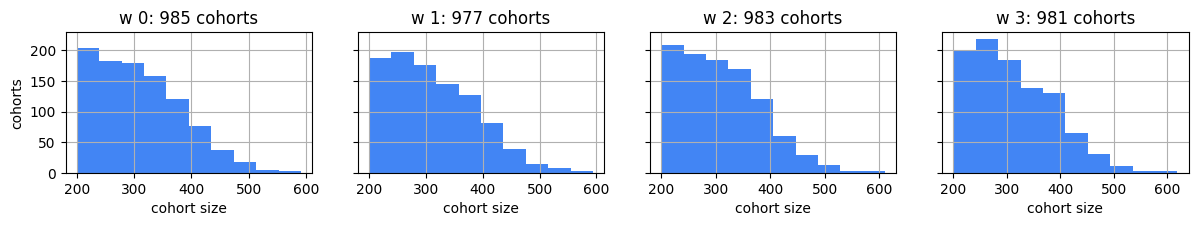

for k=400


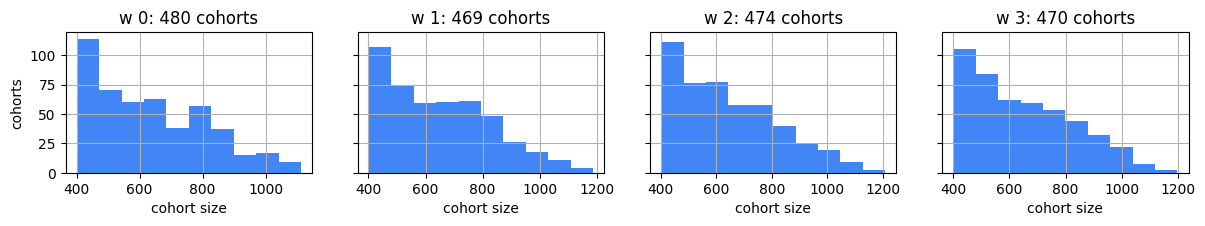

for k=600


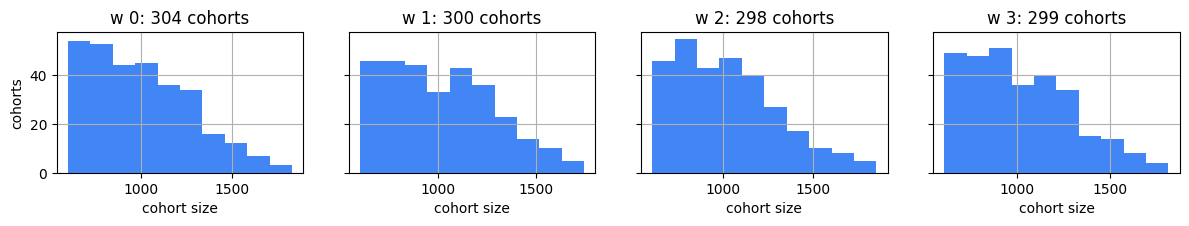

for k=800


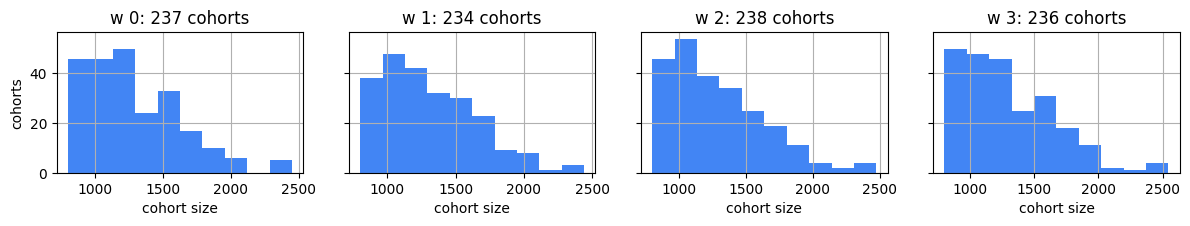

for k=1000


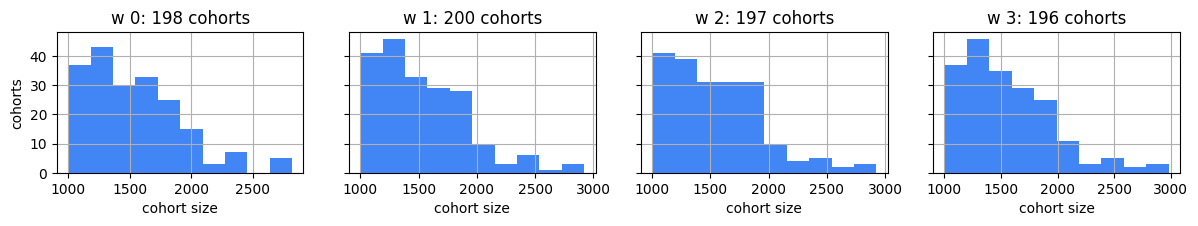

for k=1200


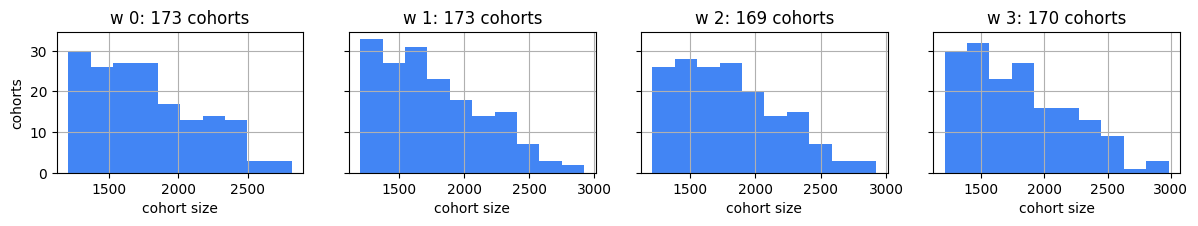

for k=1400


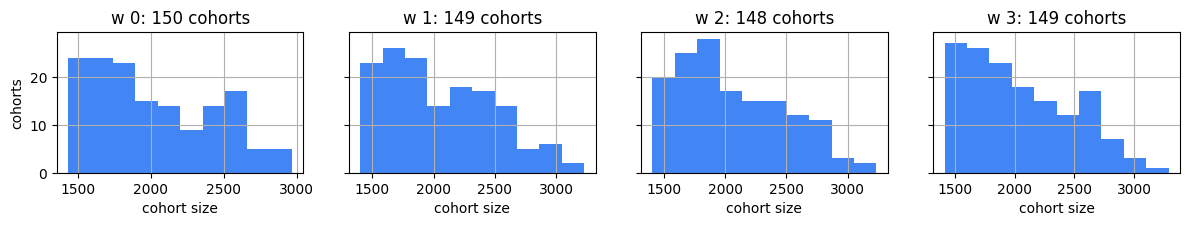

for k=1600


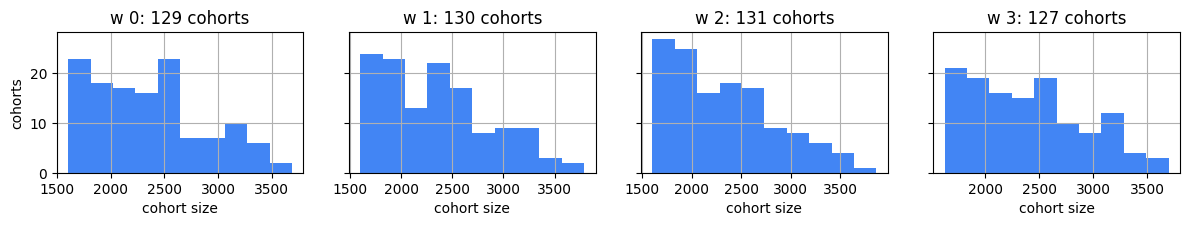

for k=1800


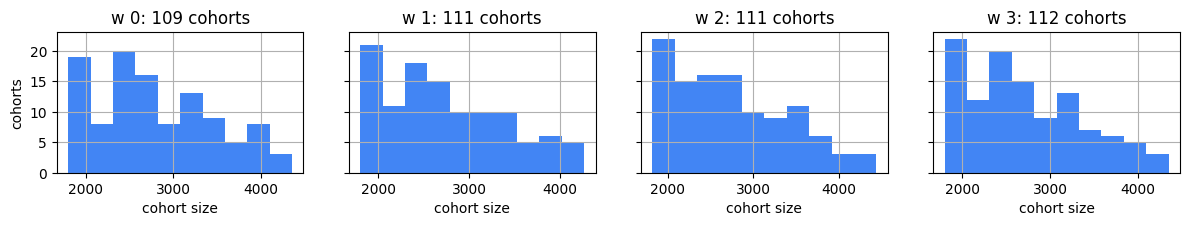

for k=2000


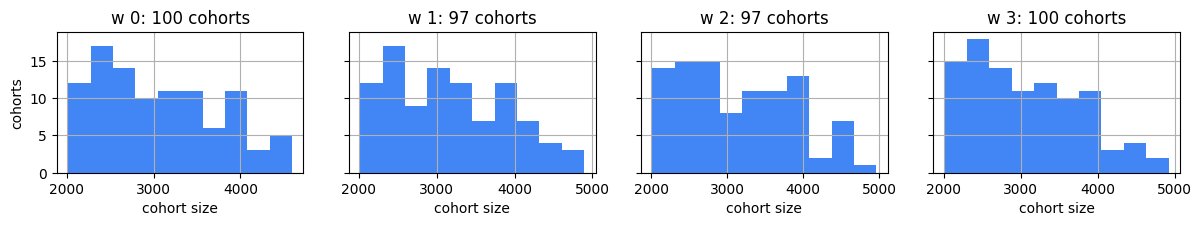

In [20]:
for (k, c) in zip(cohort_ks, cohort_k_columns):
    print('for k=%s'%k)
    fig, axes = plt.subplots(1, W, figsize=(W*3, 2), sharey=True, dpi=100)
    plt.tight_layout()
    for i, w in enumerate(range(W)):
        ax = axes[i]
        wmd_s_df[wmd_s_df.w == w][c].value_counts().hist(ax=ax, color=BLUE)
        ax.set_title('w %s: %s cohorts' % (w, wmd_s_df[wmd_s_df.w == w][c].nunique()))
        ax.set_xlabel("cohort size")
    _ = axes[0].set_ylabel("cohorts")
    plt.show()

In [21]:
wmd_s_df.head()

,machine_id,week,n_domains,domains,simhash,s,w,s_machine_id,cohort_k200,cohort_k400,cohort_k600,cohort_k800,cohort_k1000,cohort_k1200,cohort_k1400,cohort_k1600,cohort_k1800,cohort_k2000
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,0,0,0_169007206,134.0,61.0,41.0,31.0,28.0,24.0,21.0,17.0,14.0,13.0
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,0,0,0_170422065,414.0,192.0,127.0,99.0,86.0,73.0,63.0,53.0,43.0,41.0
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,0,0,0_170911221,589.0,278.0,182.0,140.0,121.0,105.0,90.0,77.0,65.0,59.0
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14,0,0,0_171771316,535.0,248.0,166.0,128.0,110.0,95.0,82.0,70.0,58.0,53.0
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14,0,0,0_176278357,780.0,381.0,242.0,188.0,158.0,139.0,119.0,103.0,89.0,80.0


Make table

weekly s_machine_id cohorts `w_smid_cohorts_s`

```
s_machine_id, state, w0_cohortkK, ...,  w4_cohortkK
```

where 
- each w1_cohortkK corresponds to the cohort assignment for w:1 for k=K for that s_machine_id. etc
- state is the u.s. state for the machine with s_machine_id


make table for uniqueness of cohort assignments `w_unicity_s`

```
w, cohortkK, state_cohortkK
```

where
- cohortkK is the fraction of s_machine_id's that have unique sequences by week w using cohorts assigned with k=K
- state_cohortkK is the fraction of s_machine_id's that have unique sequences by week w using cohorts assigned with k=K and combining sequence and state (fingerprinting) data

In [22]:
wmd_s_df.head()

,machine_id,week,n_domains,domains,simhash,s,w,s_machine_id,cohort_k200,cohort_k400,cohort_k600,cohort_k800,cohort_k1000,cohort_k1200,cohort_k1400,cohort_k1600,cohort_k1800,cohort_k2000
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,0,0,0_169007206,134.0,61.0,41.0,31.0,28.0,24.0,21.0,17.0,14.0,13.0
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,0,0,0_170422065,414.0,192.0,127.0,99.0,86.0,73.0,63.0,53.0,43.0,41.0
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,0,0,0_170911221,589.0,278.0,182.0,140.0,121.0,105.0,90.0,77.0,65.0,59.0
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14,0,0,0_171771316,535.0,248.0,166.0,128.0,110.0,95.0,82.0,70.0,58.0,53.0
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14,0,0,0_176278357,780.0,381.0,242.0,188.0,158.0,139.0,119.0,103.0,89.0,80.0


In [23]:
s_machine_to_state = wmd_s_df.set_index('s_machine_id').drop_duplicates(subset=['machine_id'])['machine_id'].map(machine_state_df['state']).sort_index()
s_machine_to_state.head()

s_machine_id
0_100607252     TX
0_113363130     IL
0_120603212     WI
0_122998696    NaN
0_124374318     OK
Name: machine_id, dtype: object

In [24]:
wmd_s_df = wmd_s_df.set_index('s_machine_id').sort_index()
w_smid_cohorts_s_df = pd.DataFrame({
    's_machine_id': sorted(wmd_s_df.index.unique()),
}).set_index('s_machine_id')
w_smid_cohorts_s_df['state'] = w_smid_cohorts_s_df.index.map(s_machine_to_state)
for c in cohort_k_columns:
    for w in range(W):
        w_smid_cohorts_s_df['w%s_%s'%(w, c)] = wmd_s_df[wmd_s_df.w==w][c].astype(int)
w_smid_cohorts_s_df.head(8)

,state,w0_cohort_k200,w1_cohort_k200,w2_cohort_k200,w3_cohort_k200,w0_cohort_k400,w1_cohort_k400,w2_cohort_k400,w3_cohort_k400,w0_cohort_k600,...,w2_cohort_k1600,w3_cohort_k1600,w0_cohort_k1800,w1_cohort_k1800,w2_cohort_k1800,w3_cohort_k1800,w0_cohort_k2000,w1_cohort_k2000,w2_cohort_k2000,w3_cohort_k2000
s_machine_id,,,,,,,,,,,,,,,,,,,,,
0_100607252,TX,302,520,240,318,140,240,108,142,91,...,31,40,31,57,26,35,29,51,23,31
0_113363130,IL,301,89,93,412,140,41,42,184,91,...,12,51,31,9,9,44,29,9,9,40
0_120603212,WI,257,437,825,723,119,198,397,343,77,...,109,92,27,46,92,82,25,43,81,74
0_122998696,NaN,262,656,547,438,121,309,257,196,79,...,70,55,28,74,58,48,26,65,53,43
0_124374318,OK,219,802,422,479,101,385,193,218,66,...,53,60,23,91,43,53,21,80,40,47
0_125424162,VA,100,631,640,571,45,298,306,263,30,...,83,72,9,70,69,64,9,63,63,57
0_127266303,ME,385,612,520,323,179,287,242,144,117,...,67,41,40,67,55,36,38,60,50,32
0_129586098,CO,273,215,963,375,127,100,465,169,81,...,129,48,29,24,109,41,27,21,96,37


Note: It should not be surprising that cohort IDs are not repeated across weeks because the cohorts are computed separately for each week, and therefore have different semantic meaning each week.

In [27]:
total = len(w_smid_cohorts_s_df)
print('%s = total number of smids' % total)
# when we groupby, we do not dropna. i.e. machines will null state data are counted
# and null state is considered like another state

w_unicity_s_df = pd.DataFrame({'w':range(W)}).set_index('w')

for c in cohort_k_columns:
    c_w_sizes = []
    c_state_w_sizes = []
    for w in range(W):
        w_cols = ['w%s_%s' % (wi, c) for wi in range(w+1)]
        state_w_cols = ['state'] + ['w%s_%s' % (wi, c) for wi in range(w+1)]
        # in the first week, all cohort sequences are size >= k
        cohort_w_seq_sizes = w_smid_cohorts_s_df.groupby(
            w_cols
        ).size().values
        cohort_state_w_seq_sizes = w_smid_cohorts_s_df.groupby(
            state_w_cols, dropna=False
        ).size().values
        # how many are size 1?
        cohort_w_seq_unique = sum(cohort_w_seq_sizes == 1)
        cohort_state_w_seq_unique = sum(cohort_state_w_seq_sizes == 1)
        # sanity check: totals / denominators should always be the same size
        assert(total==cohort_w_seq_sizes.sum())
        assert(total==cohort_state_w_seq_sizes.sum())
        #assert(state_total==cohort_state_w_seq_sizes.sum())
        c_w_sizes += [cohort_w_seq_unique/total]
        c_state_w_sizes += [cohort_state_w_seq_unique/total]
    w_unicity_s_df[c] = c_w_sizes
    w_unicity_s_df['state_%s'%c] = c_state_w_sizes
w_unicity_s_df

305312 = total number of smids


,cohort_k200,state_cohort_k200,cohort_k400,state_cohort_k400,cohort_k600,state_cohort_k600,cohort_k800,state_cohort_k800,cohort_k1000,state_cohort_k1000,cohort_k1200,state_cohort_k1200,cohort_k1400,state_cohort_k1400,cohort_k1600,state_cohort_k1600,cohort_k1800,state_cohort_k1800,cohort_k2000,state_cohort_k2000
w,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.039792,0.000000,0.018368,0.000000,0.010196,0.000000,0.007242,0.000000,0.005575,0.000000,0.004530,0.000000,0.003577,0.000000,0.002794,0.000000,0.002126,0.000000,0.001821
1,0.638000,0.734190,0.223070,0.391370,0.055281,0.228000,0.017212,0.181631,0.005974,0.164281,0.002054,0.155451,0.000544,0.148736,0.000131,0.142006,0.000023,0.133896,0.000003,0.127791
2,0.998552,0.998890,0.989814,0.992624,0.966968,0.976218,0.938054,0.955862,0.905762,0.932492,0.872124,0.907803,0.824897,0.872543,0.761644,0.825205,0.664350,0.750989,0.583610,0.687831
3,0.999948,0.999967,0.999833,0.999885,0.999519,0.999663,0.998926,0.999224,0.998231,0.998732,0.997429,0.998159,0.996201,0.997334,0.993797,0.995555,0.989332,0.992323,0.984144,0.988576


In [28]:
w_unicity_s_df.head()

,cohort_k200,state_cohort_k200,cohort_k400,state_cohort_k400,cohort_k600,state_cohort_k600,cohort_k800,state_cohort_k800,cohort_k1000,state_cohort_k1000,cohort_k1200,state_cohort_k1200,cohort_k1400,state_cohort_k1400,cohort_k1600,state_cohort_k1600,cohort_k1800,state_cohort_k1800,cohort_k2000,state_cohort_k2000
w,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.039792,0.000000,0.018368,0.000000,0.010196,0.000000,0.007242,0.000000,0.005575,0.000000,0.004530,0.000000,0.003577,0.000000,0.002794,0.000000,0.002126,0.000000,0.001821
1,0.638000,0.734190,0.223070,0.391370,0.055281,0.228000,0.017212,0.181631,0.005974,0.164281,0.002054,0.155451,0.000544,0.148736,0.000131,0.142006,0.000023,0.133896,0.000003,0.127791
2,0.998552,0.998890,0.989814,0.992624,0.966968,0.976218,0.938054,0.955862,0.905762,0.932492,0.872124,0.907803,0.824897,0.872543,0.761644,0.825205,0.664350,0.750989,0.583610,0.687831
3,0.999948,0.999967,0.999833,0.999885,0.999519,0.999663,0.998926,0.999224,0.998231,0.998732,0.997429,0.998159,0.996201,0.997334,0.993797,0.995555,0.989332,0.992323,0.984144,0.988576


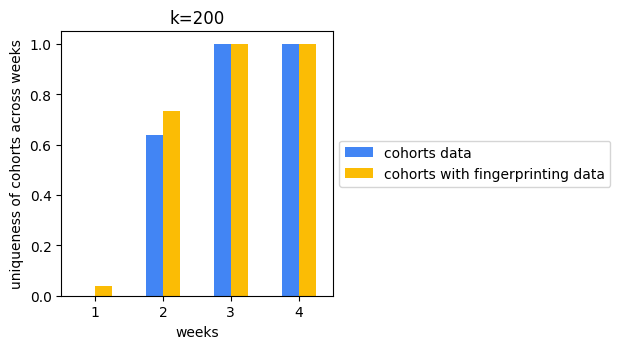

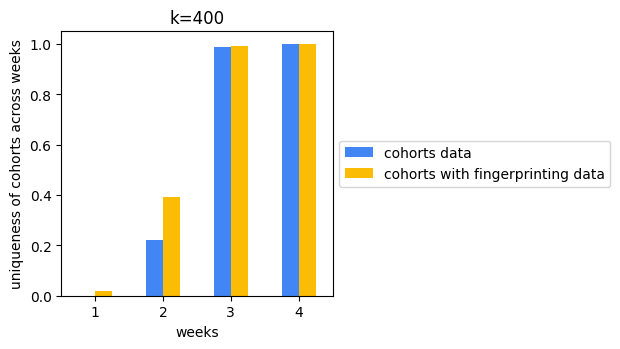

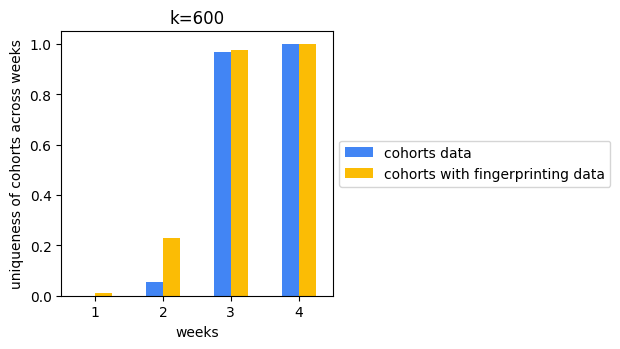

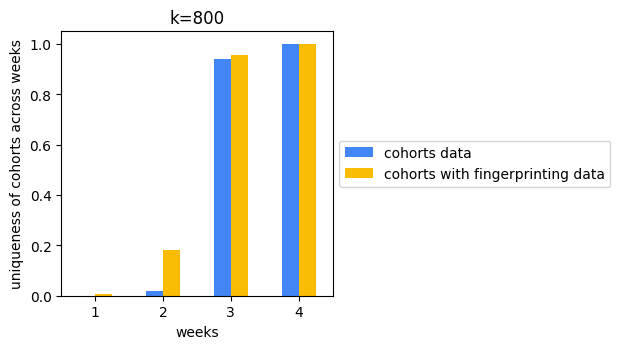

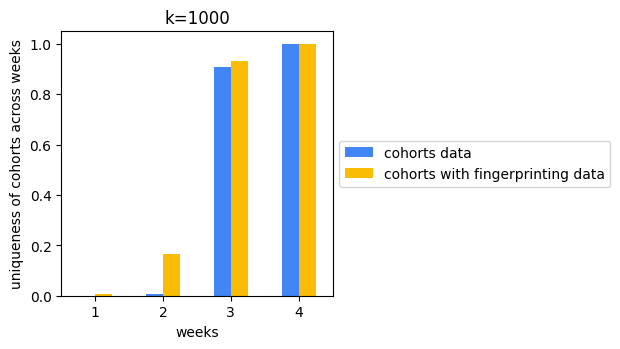

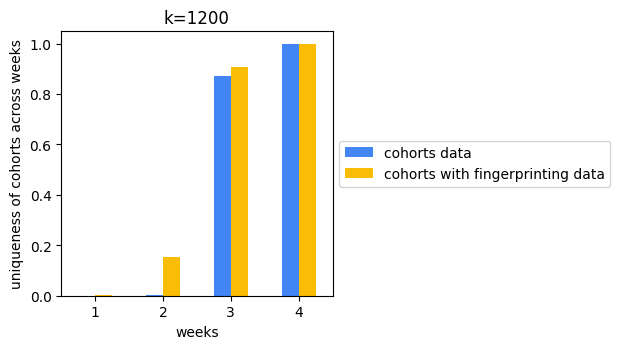

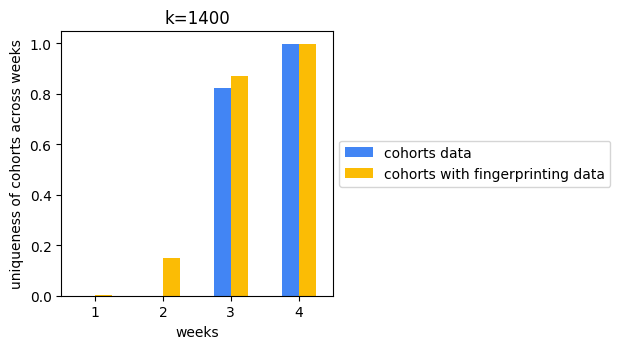

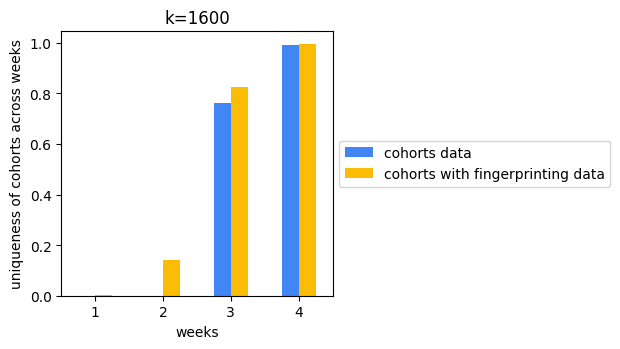

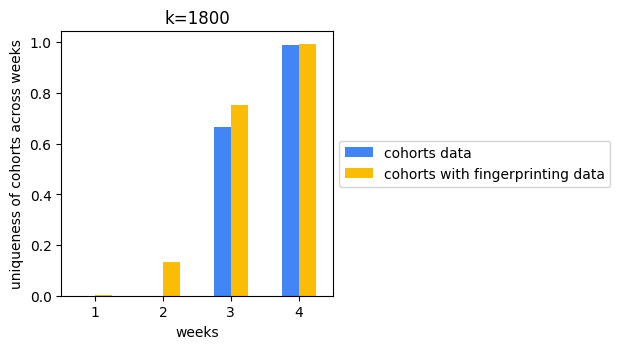

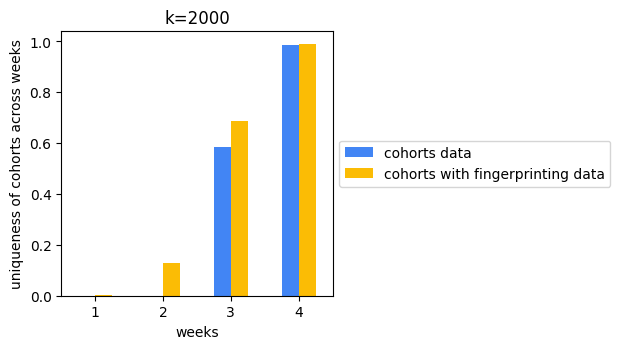

In [29]:
for (k,c) in zip(cohort_ks, cohort_k_columns):
    fig,ax = plt.subplots(1,1,figsize=(3.5,3.5),dpi=100)
    w_unicity_s_df.reset_index().plot(
        x='w',
        y=[c, 'state_%s'%c],
        color=[BLUE, ORANGE],
        kind='bar',
        ax=ax,
    )
    ax.set_title('k=%s'%k)
    ax.set_ylabel('uniqueness of cohorts across weeks')
    ax.set_xlabel('weeks')
    ax.set_xticklabels(list(range(1,W+1)), rotation=0)
    _ = ax.legend(['cohorts data','cohorts with fingerprinting data'], 
                  loc='center left', bbox_to_anchor=(1, 0.5))

It makes sense that smaller k has worse privacy implications because there are more cohorts when k is smaller. Therefore, from week to week, there are more potential cohorts for a machine to belong to.

Plot for just k=2000 (using all machines data)

k=2000


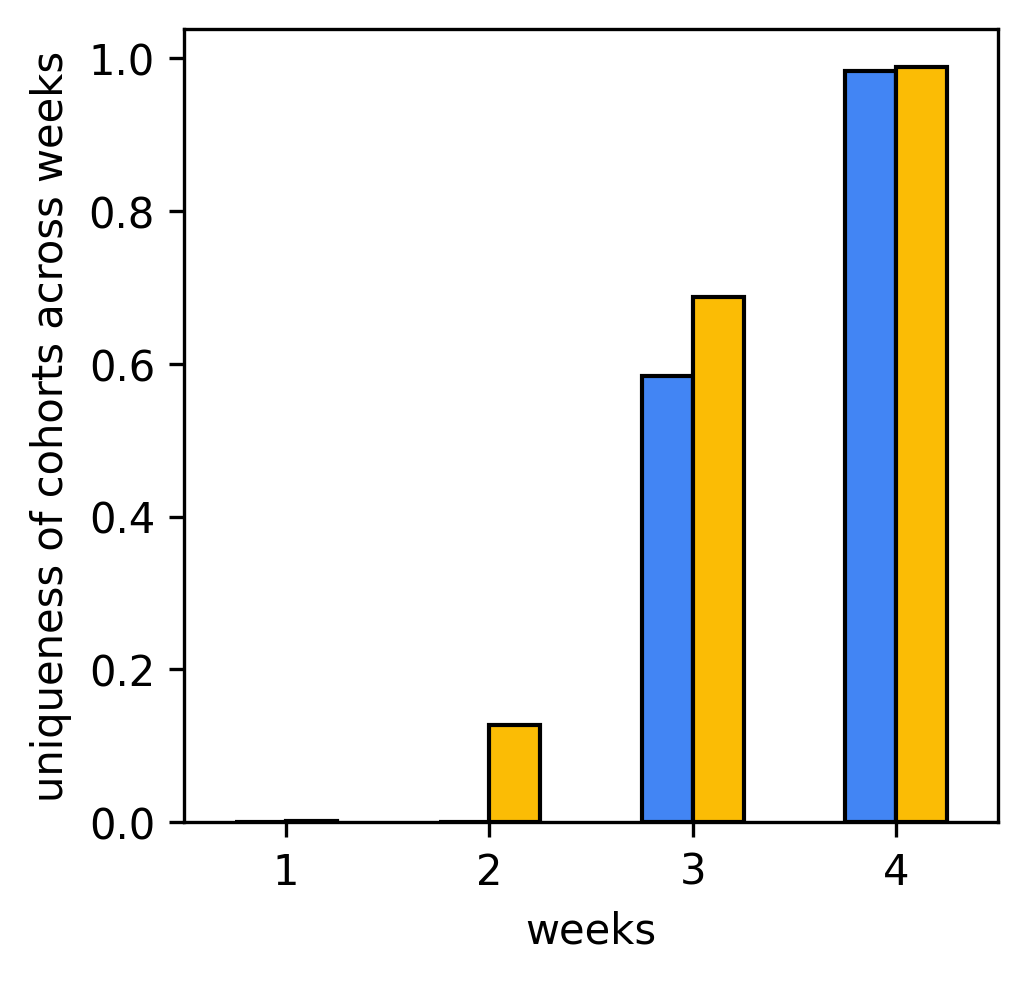

In [30]:
c = 'cohort_k2000'
k = 2000
print('k=%s'%k)

dpi=300
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5),dpi=dpi)
w_unicity_s_df.reset_index().plot(
    x='w',
    y=[c, 'state_%s'%c],
    color=[BLUE, ORANGE],
    edgecolor='black',
    kind='bar',
    ax=ax,
)
ax.set_ylabel('uniqueness of cohorts across weeks')
ax.set_xlabel('weeks')
ax.set_xticklabels(list(range(1,W+1)), rotation=0)
ax.get_legend().remove()
# _ = ax.legend(
#     ['cohorts data','cohorts with fingerprinting data'],
#     # loc='center left', bbox_to_anchor=(1, 0.5) # show at left of plot
#     loc='upper center', bbox_to_anchor=(0.5, 1.22) # show above plot
# )

For the various values of k, plot the number of weeks it takes until X% of machines uniquely identifiable. X=95.

Make a table: min_weeks_Xunicity_by_k_df
```
k, weeks, state_weeks
```

where for each k
- weeks is the min number of weeks until X% machines uniquely identifiable with just cohort IDs
- state_weeks is min number of weeks until X% machines uniquely identifiable using both cohort IDs and state (fingerprinting) data

In [31]:
w_unicity_s_df.head()

,cohort_k200,state_cohort_k200,cohort_k400,state_cohort_k400,cohort_k600,state_cohort_k600,cohort_k800,state_cohort_k800,cohort_k1000,state_cohort_k1000,cohort_k1200,state_cohort_k1200,cohort_k1400,state_cohort_k1400,cohort_k1600,state_cohort_k1600,cohort_k1800,state_cohort_k1800,cohort_k2000,state_cohort_k2000
w,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.039792,0.000000,0.018368,0.000000,0.010196,0.000000,0.007242,0.000000,0.005575,0.000000,0.004530,0.000000,0.003577,0.000000,0.002794,0.000000,0.002126,0.000000,0.001821
1,0.638000,0.734190,0.223070,0.391370,0.055281,0.228000,0.017212,0.181631,0.005974,0.164281,0.002054,0.155451,0.000544,0.148736,0.000131,0.142006,0.000023,0.133896,0.000003,0.127791
2,0.998552,0.998890,0.989814,0.992624,0.966968,0.976218,0.938054,0.955862,0.905762,0.932492,0.872124,0.907803,0.824897,0.872543,0.761644,0.825205,0.664350,0.750989,0.583610,0.687831
3,0.999948,0.999967,0.999833,0.999885,0.999519,0.999663,0.998926,0.999224,0.998231,0.998732,0.997429,0.998159,0.996201,0.997334,0.993797,0.995555,0.989332,0.992323,0.984144,0.988576


In [32]:
X = 0.95
weeks = []
state_weeks = []
for (k,c) in zip(cohort_ks, cohort_k_columns):
    weeks += [w_unicity_s_df[c][(w_unicity_s_df[c] >= X)].reset_index()['w'].values[0] + 1]
    state_weeks += [w_unicity_s_df['state_%s'%c][(w_unicity_s_df['state_%s'%c] >= X)].reset_index()['w'].values[0] + 1]
    
min_weeks_Xunicity_by_k_df = pd.DataFrame({
    'k': cohort_ks,
    'weeks': weeks,
    'state_weeks': state_weeks,
}).sort_values('k').set_index('k')
min_weeks_Xunicity_by_k_df

,weeks,state_weeks
k,,
200,3,3
400,3,3
600,3,3
800,4,3
1000,4,4
1200,4,4
1400,4,4
1600,4,4
1800,4,4


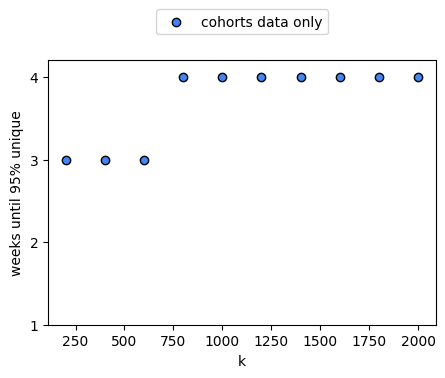

In [33]:
df = min_weeks_Xunicity_by_k_df

fig, ax = plt.subplots(1,1, figsize=(5, 3.5), dpi=100)
ax.set_ylabel('weeks until 95% unique')
ax.set_yticks([1,2,3,4])
ax.set_ylim([1, 4.2])
ax.set_xlabel('k')
ax.scatter(
    df.index, df.weeks,
    label='cohorts data only',
    marker='o',
    edgecolor='black',
    color=BLUE,
    alpha=1,
)
# ax.scatter(
#     df.index, df.state_weeks,
#     label='cohorts with fingerprinting data',
#     marker='s',
#     edgecolor='black',
#     color=ORANGE,
#     alpha=0.5,
# )
_ = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22)) # show above plot

Fix k=2000 and measure uniquely identifiable for varying number of machines, M, in the dataset.

There are > 300,000 s_machine_ids in our data.

For simplicity, we choose |M|=10 sample sizes increasing in linear increments of 20,000, from M=20,000 to M=200,000

M=[20,000, 40,000, …, 200,000]


Create 10 dfs: [wmd_s_m_df for m in M] 

for each m in M, randomly sample m s_machine_id's and subsample table.
```
s_machine_id, w, simhash
```

for each df, compute cohorts and attach state data

In [34]:
smids = set(wmd_s_df.index)
len(smids)

305312

In [35]:
M = list(range(20000,200000+1,20000))
M

[20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000]

In [36]:
import random

random.seed(0)

wmd_s_m_dfs = []
for m in M:
    smids_m = random.sample(smids, k=m)
    wmd_s_m_dfs += [wmd_s_df.loc[smids_m][['w','simhash']]]

assert(len(wmd_s_m_dfs)==len(M))

In [37]:
wmd_s_m_dfs[0].head()

,w,simhash
s_machine_id,,
3_226836106,2,1.891334e+14
3_226836106,1,2.243567e+14
3_226836106,0,2.028776e+14
3_226836106,3,7.658616e+14
2_218892746,1,1.092054e+15


In [38]:
k=2000

for i, df in enumerate(wmd_s_m_dfs):
    t_start = datetime.now()
    df['cohort'] = np.nan
    print('%s/%s - computing cohorts for m=%s (k=%s)' % (i, len(wmd_s_m_dfs),M[i],k))
    for w in range(W):
        w_df = df[(df.w==w)]
        cohorts_dict = prefixLSH.get_cohorts_dict(w_df.simhash.astype(int), min_k=k)
        assign_cohort = lambda x: cohorts_dict[x.simhash] if x.w == w else x['cohort']
        df['cohort'] = df.apply(assign_cohort, axis=1)
    print('took %s' % (datetime.now() - t_start))

0/10 - computing cohorts for m=20000 (k=2000)
took 0:00:05.548034
1/10 - computing cohorts for m=40000 (k=2000)
took 0:00:11.225687
2/10 - computing cohorts for m=60000 (k=2000)
took 0:00:16.525587
3/10 - computing cohorts for m=80000 (k=2000)
took 0:00:22.039369
4/10 - computing cohorts for m=100000 (k=2000)
took 0:00:27.627340
5/10 - computing cohorts for m=120000 (k=2000)
took 0:00:32.363914
6/10 - computing cohorts for m=140000 (k=2000)
took 0:00:38.036931
7/10 - computing cohorts for m=160000 (k=2000)
took 0:00:43.439929
8/10 - computing cohorts for m=180000 (k=2000)
took 0:00:49.627687
9/10 - computing cohorts for m=200000 (k=2000)
took 0:00:56.805845


In [39]:
wmd_s_m_dfs[0].head()

,w,simhash,cohort
s_machine_id,,,
3_226836106,2,1.891334e+14,2.0
3_226836106,1,2.243567e+14,2.0
3_226836106,0,2.028776e+14,2.0
3_226836106,3,7.658616e+14,5.0
2_218892746,1,1.092054e+15,7.0


How many total cohorts? How many in each cohort? (For a given week)

for m=20000 (k=2000)


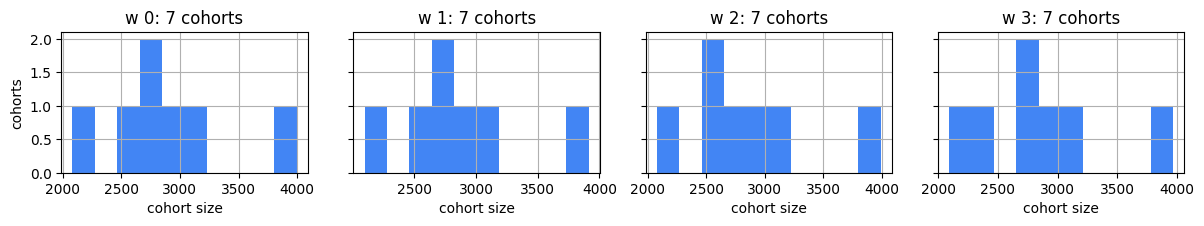

for m=40000 (k=2000)


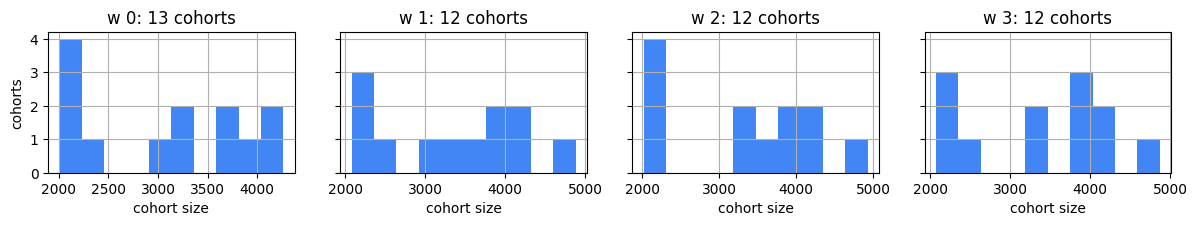

for m=60000 (k=2000)


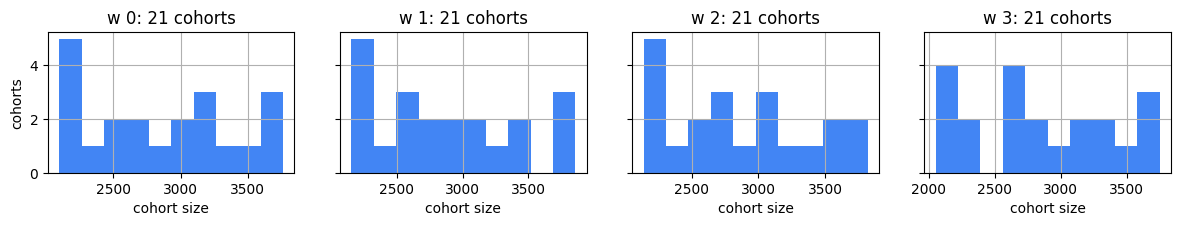

for m=80000 (k=2000)


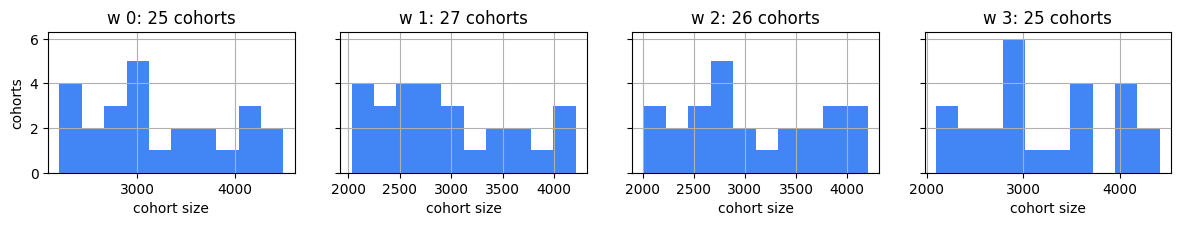

for m=100000 (k=2000)


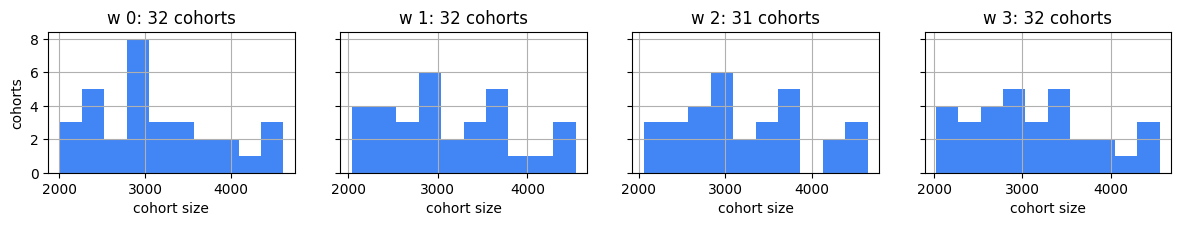

for m=120000 (k=2000)


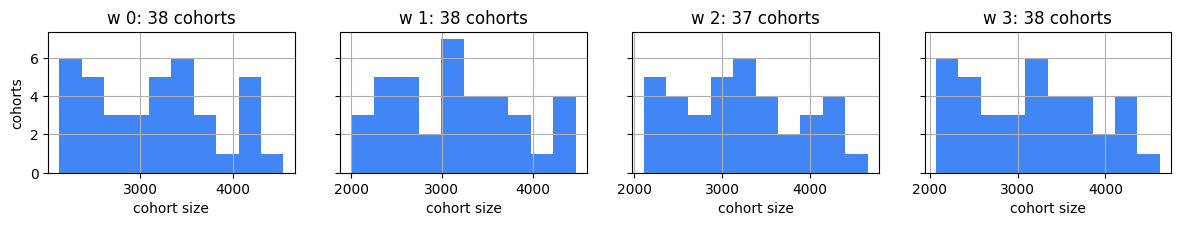

for m=140000 (k=2000)


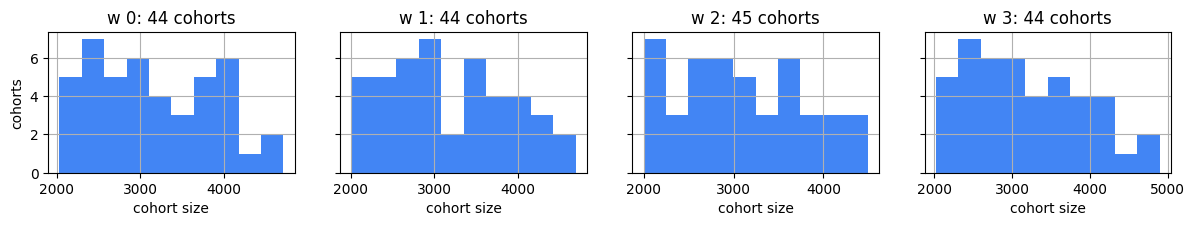

for m=160000 (k=2000)


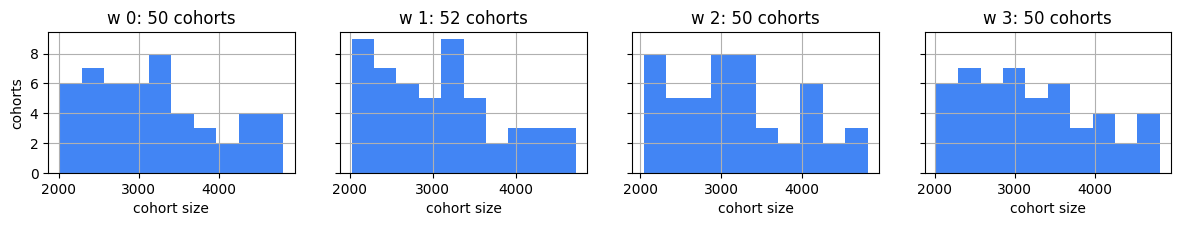

for m=180000 (k=2000)


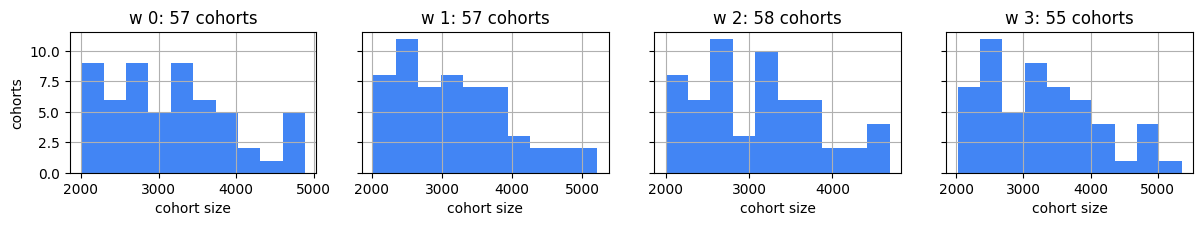

for m=200000 (k=2000)


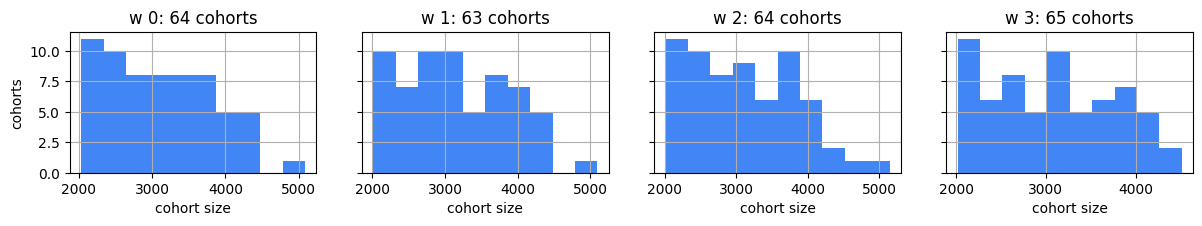

In [40]:
for i, df in enumerate(wmd_s_m_dfs):
    print('for m=%s (k=%s)' % (M[i],k))
    fig, axes = plt.subplots(1, W, figsize=(W*3, 2), sharey=True, dpi=100)
    plt.tight_layout()
    for i, w in enumerate(range(W)):
        ax = axes[i]
        df[df.w == w]['cohort'].value_counts().hist(ax=ax, color=BLUE)
        ax.set_title('w %s: %s cohorts' % (w, df[df.w == w]['cohort'].nunique()))
        ax.set_xlabel("cohort size")
    _ = axes[0].set_ylabel("cohorts")
    plt.show()

Create tables from each of these dfs:

```
s_machine_id, state, w0_cohort, w1_cohort, w2_cohort, w3_cohort
```

In [41]:
wmd_smid_cohorts_m_dfs = []
for i, df in enumerate(wmd_s_m_dfs):
    df = df.sort_index()
    wmd_smid_cohorts_m_df = pd.DataFrame({
        's_machine_id': sorted(df.index.unique()),
    }).set_index('s_machine_id')
    wmd_smid_cohorts_m_df['state'] = wmd_smid_cohorts_m_df.index.map(s_machine_to_state)
    for w in range(W):
        wmd_smid_cohorts_m_df['w%s_cohort'%(w)] = df[df.w==w]['cohort'].astype(int)
    wmd_smid_cohorts_m_dfs += [wmd_smid_cohorts_m_df]

In [42]:
wmd_smid_cohorts_m_dfs[0].head()

,state,w0_cohort,w1_cohort,w2_cohort,w3_cohort
s_machine_id,,,,,
0_113363130,IL,3,1,1,3
0_124374318,OK,2,6,3,4
0_127266303,ME,3,5,4,3
0_138795245,NY,3,3,7,4
0_143366732,HI,4,2,3,4


Note: It should not be surprising that cohort IDs are not repeated across weeks because the cohorts are computed separately for each week, and therefore have different semantic meaning each week.

In [43]:
w_unicity_s_dfs = []
for i, df in enumerate(wmd_smid_cohorts_m_dfs):
    total = len(df)
    w_u_s_df = pd.DataFrame({'w':range(W)}).set_index('w')
    w_sizes = []
    state_w_sizes = []
    for w in range(W):
        w_cols = ['w%s_cohort'%wi for wi in range(w+1)]
        state_w_cols = ['state'] + ['w%s_cohort'%wi for wi in range(w+1)]
        # in the first week, all cohort sequences are size >= k
        cohort_w_seq_sizes = df.groupby(
            w_cols
        ).size().values
        cohort_state_w_seq_sizes = df.groupby(
            state_w_cols, dropna=False
        ).size().values
        # how many are size 1?
        cohort_w_seq_unique = sum(cohort_w_seq_sizes == 1)
        cohort_state_w_seq_unique = sum(cohort_state_w_seq_sizes == 1)
        # sanity check: totals / denominators should always be the same size
        assert(total==cohort_w_seq_sizes.sum())
        assert(total==cohort_state_w_seq_sizes.sum())
        w_sizes += [cohort_w_seq_unique/total]
        state_w_sizes += [cohort_state_w_seq_unique/total]
    w_u_s_df['cohort'] = w_sizes
    w_u_s_df['state_cohort'] = state_w_sizes
    w_unicity_s_dfs += [w_u_s_df]

In [44]:
w_unicity_s_dfs[9].head()

,cohort,state_cohort
w,,
0,0.000000,0.001710
1,0.000000,0.111715
2,0.358835,0.504200
3,0.954535,0.967365


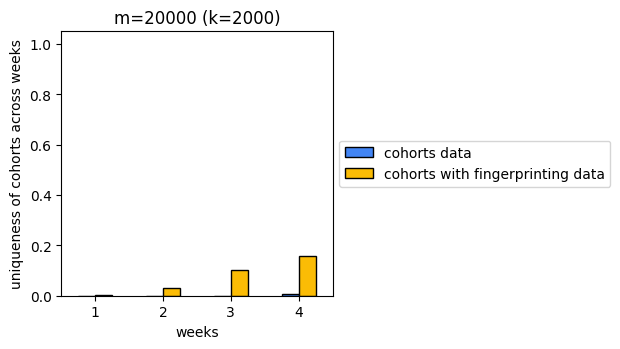

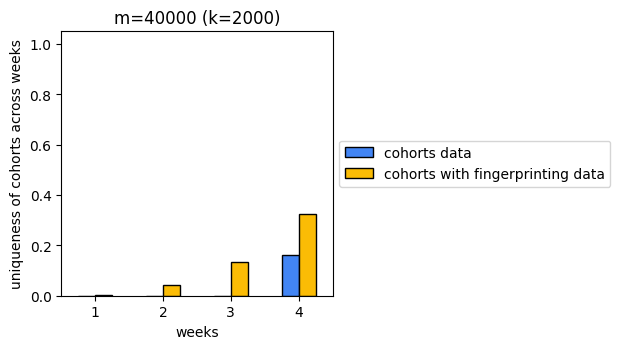

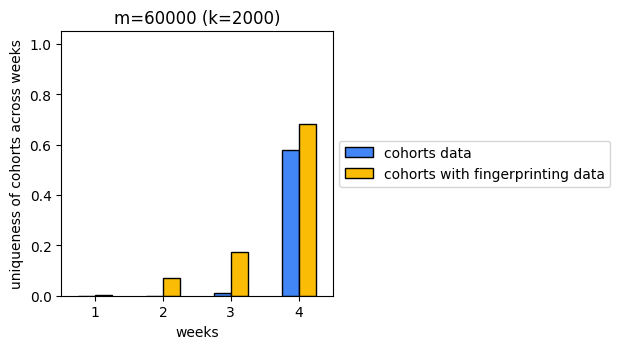

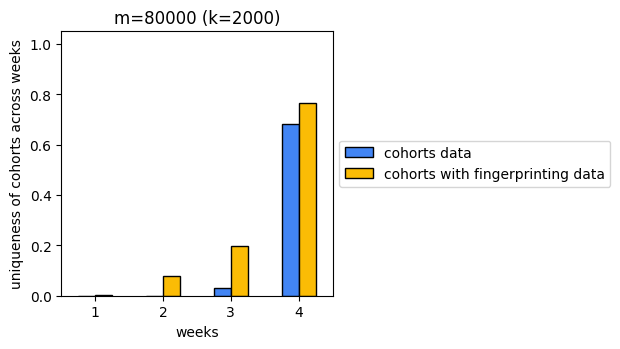

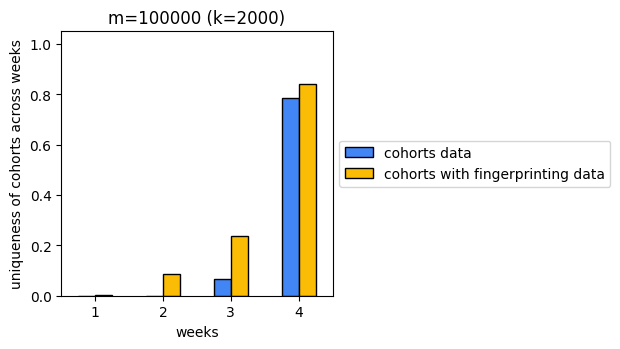

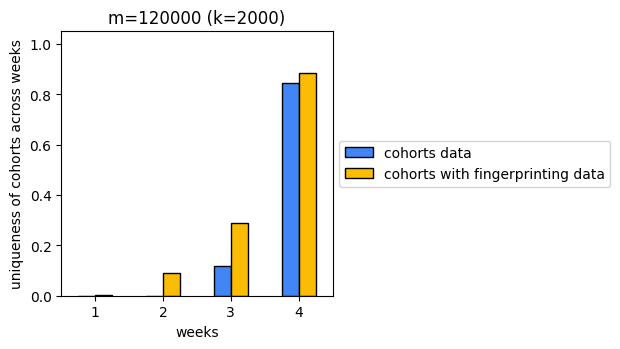

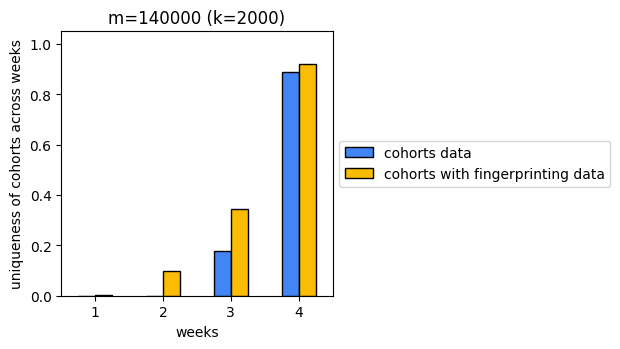

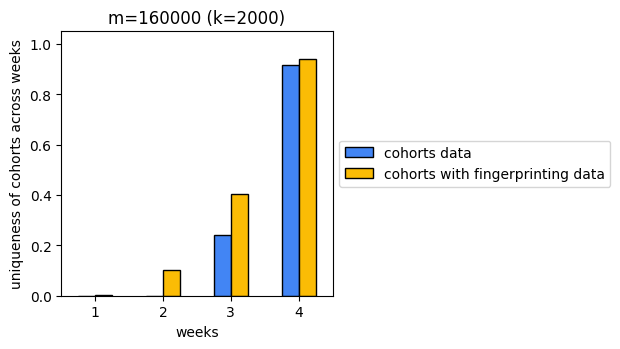

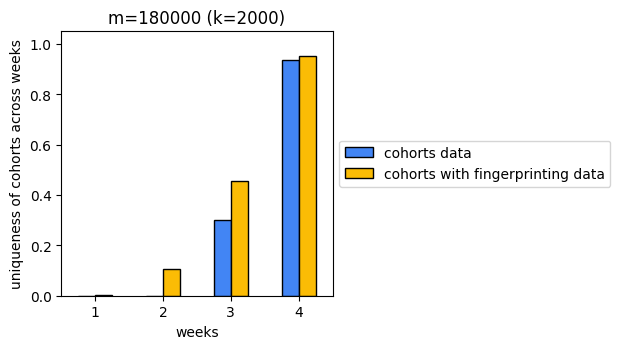

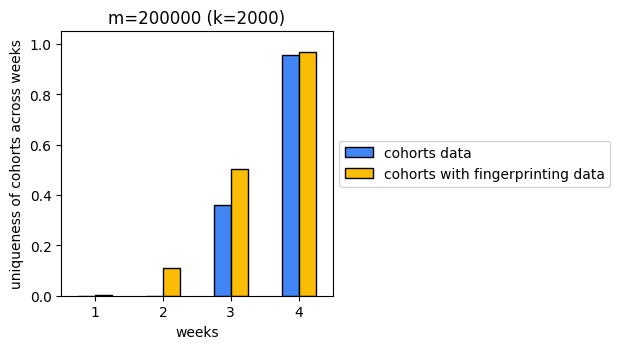

In [45]:
for i, df in enumerate(w_unicity_s_dfs):
    m = M[i]
    fig,ax = plt.subplots(1,1,figsize=(3.5,3.5),dpi=100)
    df.reset_index().plot(
        x='w',
        y=['cohort', 'state_cohort'],
        color=[BLUE, ORANGE],
        edgecolor='black',
        kind='bar',
        ax=ax,
    )
    ax.set_title('m=%s (k=%s)'%(m,k))
    ax.set_ylim(0,1.05)
    ax.set_ylabel('uniqueness of cohorts across weeks')
    ax.set_xlabel('weeks')
    ax.set_xticklabels(list(range(1,W+1)), rotation=0)
    _ = ax.legend(['cohorts data','cohorts with fingerprinting data'], 
                  loc='center left', bbox_to_anchor=(1, 0.5))

In [46]:
w_unicity_s_dfs[9]

,cohort,state_cohort
w,,
0,0.000000,0.001710
1,0.000000,0.111715
2,0.358835,0.504200
3,0.954535,0.967365


How many machines are uniquely identifiable after 3 weeks? After 4 weeks?

unicity_3_weeks_df, unicity_4_weeks_df:

```
m, cohort, state_cohort
```

where:
- cohort is the fraction of uniquely identifiable machines using just cohorts data
- state_cohort is the fraction of uniquely identifiable machines using cohorts and state (fingerprinting) data

In [47]:
unicity_3_weeks_df = pd.DataFrame({
    'm': M,
    'cohort': [df.loc[2,'cohort'] for df in w_unicity_s_dfs],
    'state_cohort': [df.loc[2,'state_cohort'] for df in w_unicity_s_dfs],
}).set_index('m').sort_index()
unicity_3_weeks_df

,cohort,state_cohort
m,,
20000,0.000000,0.103350
40000,0.000050,0.132475
60000,0.012333,0.174650
80000,0.031037,0.199513
100000,0.067340,0.237550
120000,0.116725,0.287367
140000,0.179221,0.346557
160000,0.240244,0.402919
180000,0.302117,0.457544


In [48]:
unicity_4_weeks_df = pd.DataFrame({
    'm': M,
    'cohort': [df.loc[3,'cohort'] for df in w_unicity_s_dfs],
    'state_cohort': [df.loc[3,'state_cohort'] for df in w_unicity_s_dfs],
}).set_index('m').sort_index()
unicity_4_weeks_df

,cohort,state_cohort
m,,
20000,0.005650,0.159050
40000,0.162075,0.325675
60000,0.577133,0.681600
80000,0.682288,0.764112
100000,0.785790,0.841210
120000,0.845792,0.886950
140000,0.890943,0.920329
160000,0.916713,0.939556
180000,0.936250,0.954406


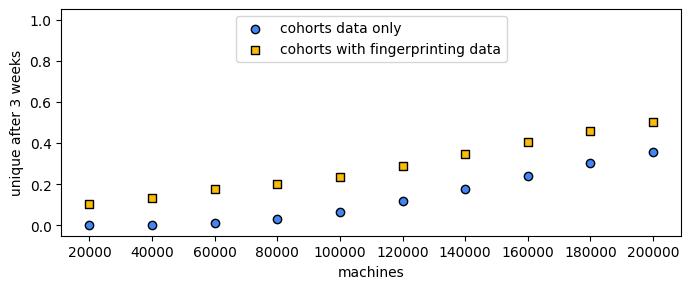

In [49]:
df = unicity_3_weeks_df

fig, ax = plt.subplots(1,1, figsize=(8, 3), dpi=100)
ax.set_ylabel('unique after 3 weeks')
ax.set_ylim([-.05, 1.05])
ax.set_xticks(M)
ax.set_xlabel('machines')
ax.scatter(
    df.index, df.cohort,
    label='cohorts data only',
    marker='o',
    edgecolor='black',
    color=BLUE,
)
ax.scatter(
    df.index, df.state_cohort,
    label='cohorts with fingerprinting data',
    marker='s',
    edgecolor='black',
    color=ORANGE,
)
_ = ax.legend(loc='upper center')#, bbox_to_anchor=(0.5, 1.22)) # show above plot

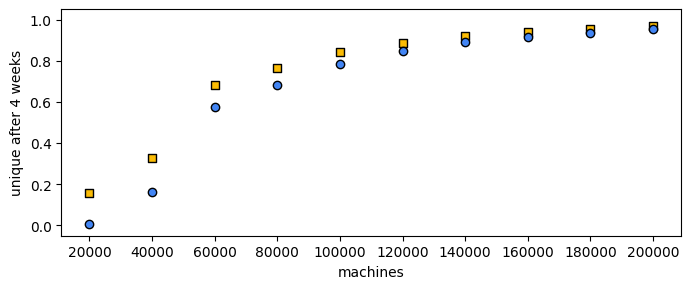

In [50]:
df = unicity_4_weeks_df

fig, ax = plt.subplots(1,1, figsize=(8, 3), dpi=100)
ax.set_ylabel('unique after 4 weeks')
ax.set_ylim([-.05, 1.05])
ax.set_xticks(M)
ax.set_xlabel('machines')
_ = ax.scatter(
    df.index, df.state_cohort,
    label='cohorts with fingerprinting data',
    marker='s',
    edgecolor='black',
    color=ORANGE,
)
_ = ax.scatter(
    df.index, df.cohort,
    label='cohorts data only',
    marker='o',
    edgecolor='black',
    color=BLUE,
)

Make a plot with both 3 and 4 weeks of data.

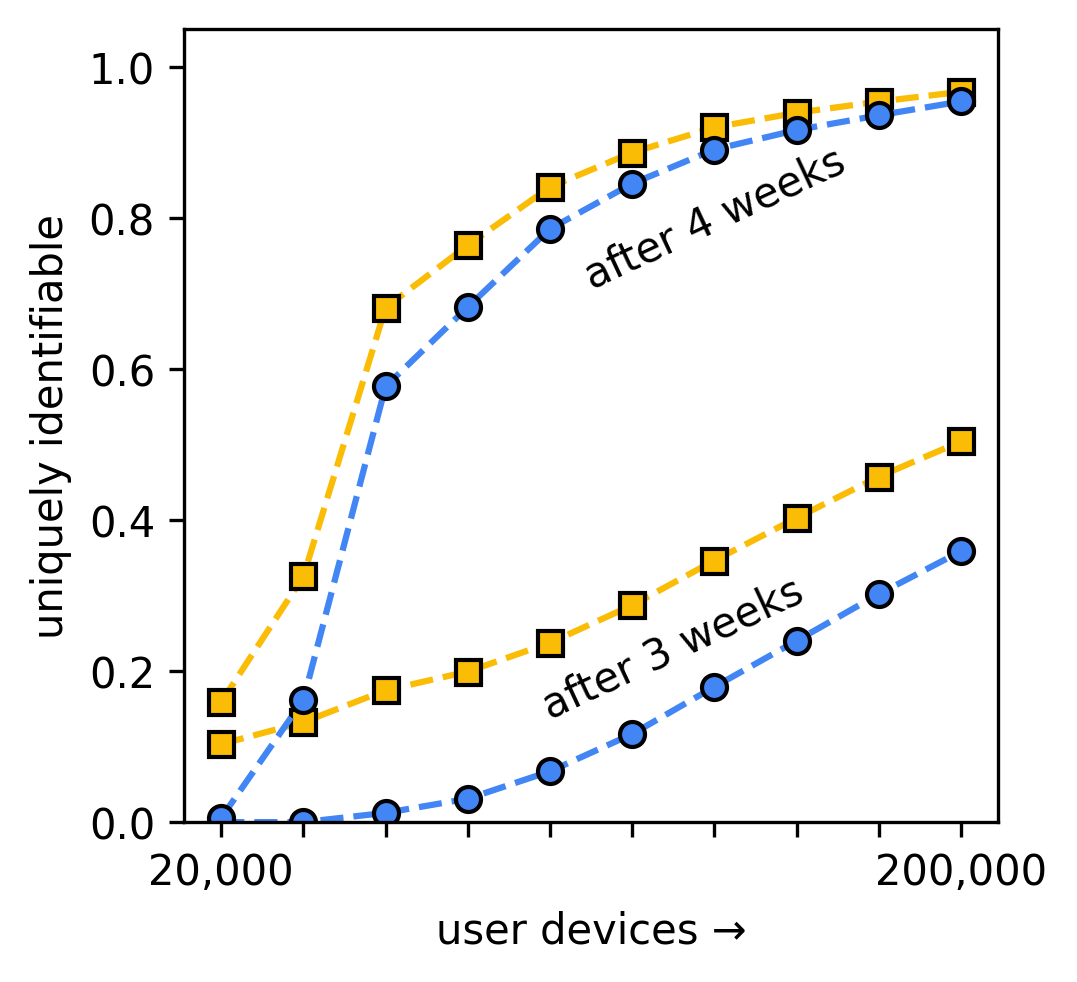

In [51]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5), dpi=300)
ax.set_ylabel('uniquely identifiable')
ax.set_ylim([0, 1.05])
ax.set_xticks(M)
xticklabels = ['20,000'] + ['']*8 + ['200,000']
ax.set_xticklabels(xticklabels)

for df in [unicity_3_weeks_df, unicity_4_weeks_df]:
    ax.set_xlabel('user devices →')
    _ = ax.plot(
        df.index, df.state_cohort,
        label='cohorts with fingerprinting data',
        marker='s',
        linestyle='--',
        markeredgecolor='black',
        color=ORANGE,
    )
    _ = ax.plot(
        df.index, df.cohort,
        label='cohorts data only',
        marker='o',
        linestyle='--',
        markeredgecolor='black',
        color=BLUE,
    )
    
ax.text(130000,0.23, 'after 3 weeks', ha="center", va="center", rotation=25)
_ = ax.text(140000,0.8, 'after 4 weeks', ha="center", va="center", rotation=25)

Make a similar plot for ranges of k

In [52]:
w_unicity_s_df.head()

,cohort_k200,state_cohort_k200,cohort_k400,state_cohort_k400,cohort_k600,state_cohort_k600,cohort_k800,state_cohort_k800,cohort_k1000,state_cohort_k1000,cohort_k1200,state_cohort_k1200,cohort_k1400,state_cohort_k1400,cohort_k1600,state_cohort_k1600,cohort_k1800,state_cohort_k1800,cohort_k2000,state_cohort_k2000
w,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.039792,0.000000,0.018368,0.000000,0.010196,0.000000,0.007242,0.000000,0.005575,0.000000,0.004530,0.000000,0.003577,0.000000,0.002794,0.000000,0.002126,0.000000,0.001821
1,0.638000,0.734190,0.223070,0.391370,0.055281,0.228000,0.017212,0.181631,0.005974,0.164281,0.002054,0.155451,0.000544,0.148736,0.000131,0.142006,0.000023,0.133896,0.000003,0.127791
2,0.998552,0.998890,0.989814,0.992624,0.966968,0.976218,0.938054,0.955862,0.905762,0.932492,0.872124,0.907803,0.824897,0.872543,0.761644,0.825205,0.664350,0.750989,0.583610,0.687831
3,0.999948,0.999967,0.999833,0.999885,0.999519,0.999663,0.998926,0.999224,0.998231,0.998732,0.997429,0.998159,0.996201,0.997334,0.993797,0.995555,0.989332,0.992323,0.984144,0.988576


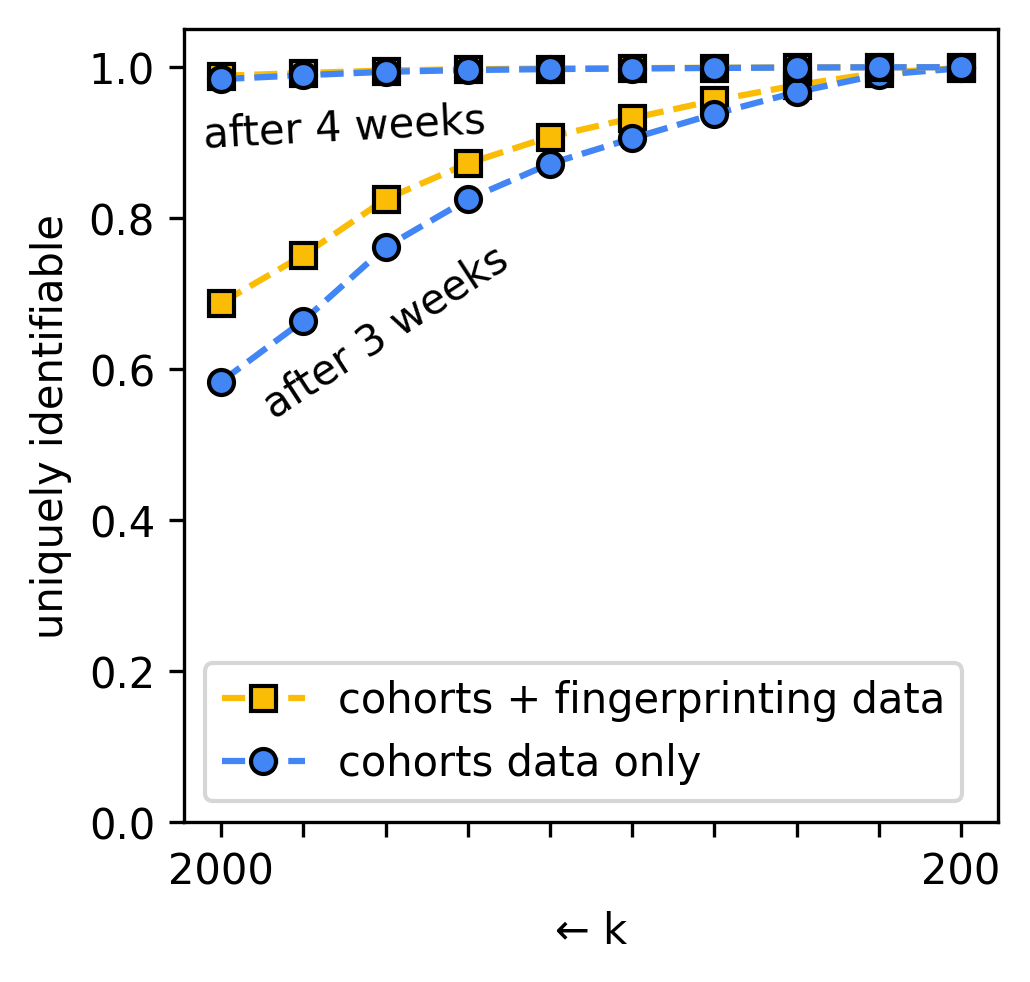

In [53]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), dpi=300)

ax.set_ylabel('uniquely identifiable')
ax.set_ylim([0, 1.05])
ax.set_xticks(list(reversed(cohort_ks)))
for w in [2, 3]:
    _ = ax.plot(
        cohort_ks, 
        list(reversed([w_unicity_s_df.loc[w,'state_%s'%c] for c in cohort_k_columns])),
        label='cohorts + fingerprinting data' if w==3 else '_nolegend_',
        marker='s',
        linestyle='--',
        markeredgecolor='black',
        color=ORANGE,
    )
    _ = ax.plot(
        cohort_ks, 
        list(reversed([w_unicity_s_df.loc[w,c] for c in cohort_k_columns])),
        label='cohorts data only' if w==3 else '_nolegend_',
        marker='o',
        linestyle='--',
        markeredgecolor='black',
        color=BLUE,
    )
# matplotlib is weird and wants me to reverse twice. Buggy. Just ensure the plot is accurate.
xticklabels = ['2000'] + ['']*8 + ['200']
ax.set_xticklabels(reversed(xticklabels)) 
ax.set_xlabel('← k')

ax.text(500,0.92, 'after 4 weeks', ha="center", va="center", rotation=3)
_ = ax.text(600,0.65, 'after 3 weeks', ha="center", va="center", rotation=33)
_ = ax.legend()